In [2]:
%load_ext rpy2.ipython

In [3]:
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects

In [4]:
import keras_core as keras
from keras_core import layers

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from chromax import Simulator, sample_data
import pathlib

Using TensorFlow backend


2023-12-26 04:56:10.887626: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-26 04:56:10.983770: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-26 04:56:11.692090: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-26 04:56:11.695559: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-26 04:56:13.239875: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [5]:

def plot_means_and_variances(dataframes):
    # Calculate the mean and variance for each dataframe
    mean_values = [df.mean() for df in dataframes]
    var_values = [df.var() for df in dataframes]
    var_values = np.array(var_values).flatten()
    mean_values = np.array(mean_values).flatten()

    # Create an array for the x-values
    x_values = range(len(dataframes))

    # Create the scatter plot with error bars
    plt.errorbar(x_values, mean_values, yerr=var_values, fmt='o')

    # Display the plot
    plt.show()


def generate_genetic_map(n_markers, n_chromosomes):
  df = pd.DataFrame(generate_marker_effects(n_markers=n_markers), columns=['Yield'])
  df['cM'] = np.random.uniform(0, 200, len(df))
  df['CHR.PHYS'] = '1A'
  df = df.sort_values(by='cM')
  df = df[['CHR.PHYS', 'cM', 'Yield']]
  # save df as csv under filename
  return df

def generate_population(n_pop=100, n_markers=500):
    """
    Generate a numpy array of randoms of length 500 with randomized 0, 1, or 2 at each position.
    It will generate 100 individuals based on n_pop.

    Returns: numpy array of size (n_pop, n_markers)
    """
    shape=(n_pop, n_markers, 2)
    # Define the elements to choose from and their associated probabilities
    elements = [0, 1, 2]
    probabilities = [1/3, 1/3, 1/3]  # equal probabilities for 0, 1, and 2

    # Generate the population
    population = np.random.choice(elements, size=(n_pop, n_markers), p=probabilities)

    return np.random.choice([True, False], size=shape)


def generate_marker_effects(n_markers=500, mu=0, sigma=0.1):
    """
    Generate a numpy array of marker effects with a normal distribution.

    Parameters:
    n_markers (int): Number of markers.
    mu (float): Mean of the distribution.
    sigma (float): Standard deviation of the distribution.

    Returns:
    numpy array of marker effects
    """

    # Generate the marker effects
    marker_effects = np.random.normal(mu, sigma, n_markers)

    return marker_effects

import numpy as np

def select_random_individuals(arr, num_individuals):
    # Get the shape of the array
    shape = arr.shape

    # Generate random indices along the first axis
    idx = np.random.choice(shape[0], size=num_individuals)

    # Select the random individuals

    return random_individuals

def select_mixed(population, random_split=.99):
  n_pop = population.shape[0]

  n_random = int(n_pop * random_split)
  n_select = int(n_pop * (1-random_split))

  random_parents = select_random_individuals(Farm.current_population, n_random)
  selected_parents = Farm.Simulator.select(Farm.current_population, k = n_select)
  combined_arr = np.concatenate((random_parents, selected_parents), axis=0)
  return combined_arr

def plot_replicate_means_and_variances(replicate_data, start_index=None, end_index=None):
    # Create a new figure and axes
    fig, ax = plt.subplots()

    # If start_index or end_index is not provided, set them to default values
    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(replicate_data[0])

    # For each list of dataframes in replicate_data
    for i, dataframes in enumerate(replicate_data):
        # Select the dataframes in the specified range
        dataframes = dataframes[start_index:end_index]

        # Calculate the mean and variance for each dataframe
        mean_values = [df.mean() for df in dataframes]
        var_values = [df.var() for df in dataframes]

        # Flatten the var_values and mean_values lists to 1D arrays
        var_values = np.array(var_values).flatten()
        mean_values = np.array(mean_values).flatten()

        # Create an array for the x-values
        x_values = range(len(dataframes))

        # Plot the means with error bars for the variances
        ax.errorbar(x_values, mean_values, yerr=var_values, fmt='o', label=f'Replicate {i+1}')

    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()


def plot_replicate_means(replicate_data):
    # Create a new figure and axes
    fig, ax = plt.subplots()

    # For each list of dataframes in replicate_data
    for i, dataframes in enumerate(replicate_data):
        # Calculate the mean for each dataframe
        mean_values = [df.mean() for df in dataframes]
        # Flatten the mean_values list to a 1D array
        mean_values = np.array(mean_values).flatten()

        # Create an array for the x-values
        x_values = range(len(dataframes))

        # Plot the means as a line plot
        ax.plot(x_values, mean_values, label=f'Replicate {i+1}')

    # Add a legend
    ax.legend()

    # Display the plot
    plt.show()

def parse_markerEffects(genetic_map, nChr):
    # Get the length of the genetic map
    length = len(genetic_map)

    # Create a new array for storing the chromosome number for each marker
    chr = [0] * length

    # Calculate the number of markers per chromosome
    markers_per_chr = length // nChr

    # Iterate over the range of the genetic map length
    for i in range(length):
        # Calculate the chromosome number and store it in the chr array
        chr[i] = i // markers_per_chr + 1

    return chr
import jax.numpy as jnp
import numpy as np

def score_top(scores: pd.DataFrame, column: str, k: int):
    # Sort the DataFrame from high to low
    sorted_scores = scores.sort_values(by=column, ascending=False)
    # Get the top K indexes
    top_k_indexes = sorted_scores.head(k).index
    return top_k_indexes


def score_top_percentile(scores: pd.DataFrame, column: str, percentile_min: float, percentile_max: float, k: int):
    # Ensure max percentile is greater than min percentile
    assert percentile_max > percentile_min, "Error: max percentile should be greater than min percentile"
    
    # Calculate the percentiles
    lower = scores[column].quantile(percentile_min)
    upper = scores[column].quantile(percentile_max)
    # Filter the DataFrame
    filtered_scores = scores[(scores[column] >= lower) & (scores[column] <= upper)]
    # Sample k random indexes
    sampled_indexes = np.random.choice(filtered_scores.index, k, replace=True)

    return sampled_indexes

def reshape_pop(maizeHaplo):
    reshapeHaplo = maizeHaplo.reshape(int((maizeHaplo.shape[0])/2),2,maizeHaplo.shape[1])
    reshapeHaplo = reshapeHaplo.transpose((0,2,1))
    return reshapeHaplo

def return_genetic_map_df(markerEffects, nChr, geneticMap):
    chr = parse_markerEffects(markerEffects, nChr)
    chr = [int(x[0]) for x in chr]
    trait = markerEffects
    pos = geneticMap
    # Assuming chr, trait, pos are your arrays
    df = pd.DataFrame({'CHR.PHYS': chr, 'Yield': trait, 'cM': pos})
    return df



In [6]:
%%R
x <- seq(0, 2*pi, length.out=50)

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


In [7]:
%R -o x

In [8]:
x

array([0.        , 0.12822827, 0.25645654, 0.38468481, 0.51291309,
       0.64114136, 0.76936963, 0.8975979 , 1.02582617, 1.15405444,
       1.28228272, 1.41051099, 1.53873926, 1.66696753, 1.7951958 ,
       1.92342407, 2.05165235, 2.17988062, 2.30810889, 2.43633716,
       2.56456543, 2.6927937 , 2.82102197, 2.94925025, 3.07747852,
       3.20570679, 3.33393506, 3.46216333, 3.5903916 , 3.71861988,
       3.84684815, 3.97507642, 4.10330469, 4.23153296, 4.35976123,
       4.48798951, 4.61621778, 4.74444605, 4.87267432, 5.00090259,
       5.12913086, 5.25735913, 5.38558741, 5.51381568, 5.64204395,
       5.77027222, 5.89850049, 6.02672876, 6.15495704, 6.28318531])

In [9]:
# %R install.packages("AlphaSimR")

In [10]:
%%R
library("AlphaSimR")

Loading required package: R6


In [11]:
%%R
nInd = 50
nChr = 3
segSites = 10

founderGenomes = runMacs(nInd = nInd,
                         nChr = nChr,
                         segSites = segSites,
                         species = "MAIZE")


In [12]:
%%R
SP = SimParam$new(founderGenomes)
SP$addTraitA(segSites)
# SP$setVarE(h2=.02)
pop = newPop(founderGenomes, simParam=SP)
ans = fastRRBLUP(pop, simParam=SP, useQtl=TRUE, use='gv')
ans@gv[[1]]@addEff
markerEffects = slot(slot(ans, "gv")[[1]], "addEff")
maizeHaplo = pullSegSiteHaplo(pop)
maizeGeno = pullSegSiteGeno(pop)
#cm positions of each marker
genMap = SP$genMap
geneticMap = unlist(genMap)

In [13]:
%R -o maizeHaplo
%R -o maizeGeno
%R -o markerEffects
%R -o geneticMap
%R -o nInd
%R -o nChr
%R -o segSites

In [21]:
class BreedingProgram:
    """
    Represents a breeding program with a PPO agent.
    """

    def __init__(self, initial_population, genetic_map, population_size, marker_count, chromosome_number, max_generation, heritability):
        """
        Initializes the breeding program.
        """

        # Initialize the basic attributes
        self.population_size = population_size
        self.marker_count = marker_count
        self.initial_population = initial_population
        self.genetic_map = genetic_map
        self.max_generation = max_generation

        # Initialize the simulator
        self.simulator = Simulator(genetic_map=self.genetic_map, h2=heritability)
        self.simulator.load_population('mypop.npy')

        # Initialize the current generation and history
        self.current_generation = 0
        self.history = []

        # Start the breeding program
        self._start_breeding_program()
        
    def _start_breeding_program(self):
        """
        Starts the breeding program.
        """
        self.current_population = self.initial_population
        self.current_scores = self.simulator.GEBV(reshape_pop(self.initial_population))
        self.history.append(self.current_scores)





initial_population = maizeGeno 
genetic_map = return_genetic_map_df(markerEffects, nChr, geneticMap)
reshapeHaplo = reshape_pop(maizeHaplo)
np.save('mypop', reshapeHaplo)


population_size = int(nInd)
marker_count = int((segSites * nChr))
chromosome_number = int(nChr)
generation_max = 10
heritability = .5

x = BreedingProgram(initial_population, genetic_map, population_size, marker_count, chromosome_number, generation_max, heritability)

In [26]:
mysim =  Simulator(genetic_map=genetic_map, h2=.5)

In [56]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Flatten

#create init population + genetic map
n = int(nInd)
m = int((segSites * nChr))

# Define the actor model
actor_input = keras.layers.Input(shape=(n, m))
x = keras.layers.Dense(64, activation='relu')(actor_input)
x = keras.layers.Dense(64, activation='relu')(x)
actor_output = keras.layers.Dense(n*2, activation='softmax')(x)
actor_model = keras.models.Model(actor_input, actor_output)
actor_model.compile(optimizer='adam', loss='categorical_crossentropy')

# Define the critic model
critic_input1 = keras.layers.Input(shape=(n, m))
critic_input2 = keras.layers.Input(shape=(n, n*2))

x1 = keras.layers.Dense(64, activation='relu')(critic_input1)
x2 = keras.layers.Dense(64, activation='relu')(critic_input2)

combined = keras.layers.concatenate([x1, x2])

x3 = keras.layers.Dense(64, activation='relu')(combined)
critic_output = keras.layers.Dense(1, activation='linear')(x3)

critic_model = keras.models.Model([critic_input1, critic_input2], critic_output)
critic_model.compile(optimizer='adam', loss='mse')

In [64]:
import numpy as np

# Create a random example
example_population = np.random.rand(1, n, m)
# Send the example through the actor network
actor_output = actor_model.predict(example_population)
print(f'actor model output : {actor_output.shape}')
print(f'example population shape, single sample : {example_population.shape}')

# Predict
critic_output = critic_model.predict([ example_population, actor_output])

# Print the output
print(f'critic model output: {critic_output.shape}')
print(critic_output[0][0:5])

1/1 [==============================] - 0s 26ms/step
actor model output : (1, 50, 100)
example population shape, single sample : (1, 50, 30)
1/1 [==============================] - 0s 18ms/step
critic model output: (1, 50, 1)
[[-0.00156942]
 [-0.05088468]
 [ 0.03886886]
 [ 0.04429071]
 [-0.14508265]]


In [ ]:
# Next steps
# 1) Given the output from actor model -> for each pair grab the parents -> use chromax to simulate offspring -> generate new population
# 2 ) probably calculate fitness / loss from the prediction from critic model
# ...
# 4 ) write training loop

In [66]:
actor_output.shape

(1, 50, 100)

In [67]:
# must decide how to format/process the output consistent
# we get 100 lists of 50 values.
# each value is probability of selecting that index for the selected parent for that pair
# pair parents is index 1/2, 3/4, 5/6 , ...
# if same parent in both slot 1/2 then we will do DH line?



In [83]:
actor_output[:,0,:]

array([[0.01245699, 0.00778389, 0.00886085, 0.00841799, 0.01184922,
        0.01305387, 0.00853923, 0.00825271, 0.00795662, 0.01067472,
        0.00998916, 0.01043354, 0.00962658, 0.01146581, 0.00808659,
        0.01063738, 0.0084182 , 0.0113223 , 0.01029607, 0.01036322,
        0.00895184, 0.01063219, 0.01177874, 0.00969121, 0.00912221,
        0.01208833, 0.01020398, 0.00978627, 0.01050029, 0.0115451 ,
        0.00981521, 0.01014281, 0.00861556, 0.01105966, 0.00990818,
        0.00969011, 0.00842253, 0.01191296, 0.00945252, 0.01103316,
        0.00907731, 0.01040156, 0.00983048, 0.00905153, 0.01007108,
        0.00834256, 0.00930037, 0.00979898, 0.01171062, 0.00779041,
        0.01013806, 0.00706989, 0.01076563, 0.01023244, 0.00702305,
        0.01056373, 0.01424958, 0.00932983, 0.01051234, 0.01032524,
        0.00827627, 0.00819154, 0.01165415, 0.00694887, 0.01137926,
        0.00846632, 0.01048918, 0.01237592, 0.01381732, 0.00760405,
        0.01046099, 0.01052367, 0.0124399 , 0.01

(array([ 10.83253876,  10.83253876,  64.99523258, 184.15315897,
        129.99046515, 270.81346907, 216.65077526, 119.15792639,
         54.16269381,  21.66507753]),
 array([0.00501813, 0.00594127, 0.00686442, 0.00778756, 0.00871071,
        0.00963385, 0.010557  , 0.01148014, 0.01240329, 0.01332643,
        0.01424958]),
 <BarContainer object of 10 artists>)

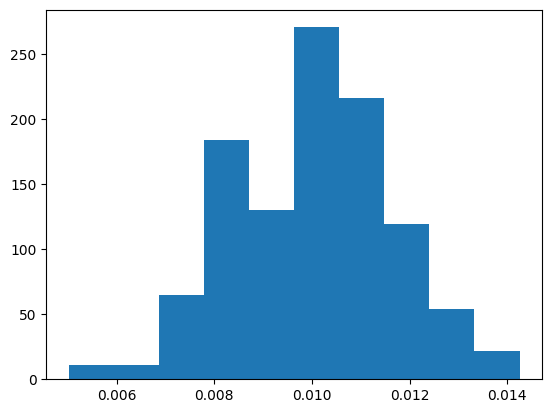

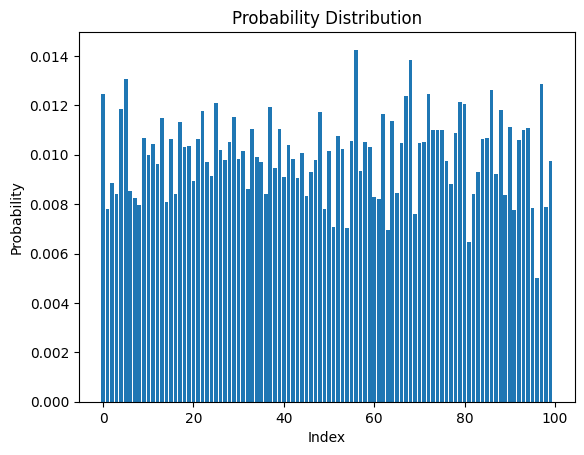

In [86]:
import matplotlib.pyplot as plt

# Your array of probabilities
probabilities = actor_output[:,0,:][0]


plt.hist(probabilities, bins='auto', density=True)

# Create an array of indices
indices = range(len(probabilities))

plt.bar(indices, probabilities)
plt.title('Probability Distribution')
plt.xlabel('Index')
plt.ylabel('Probability')
plt.show()


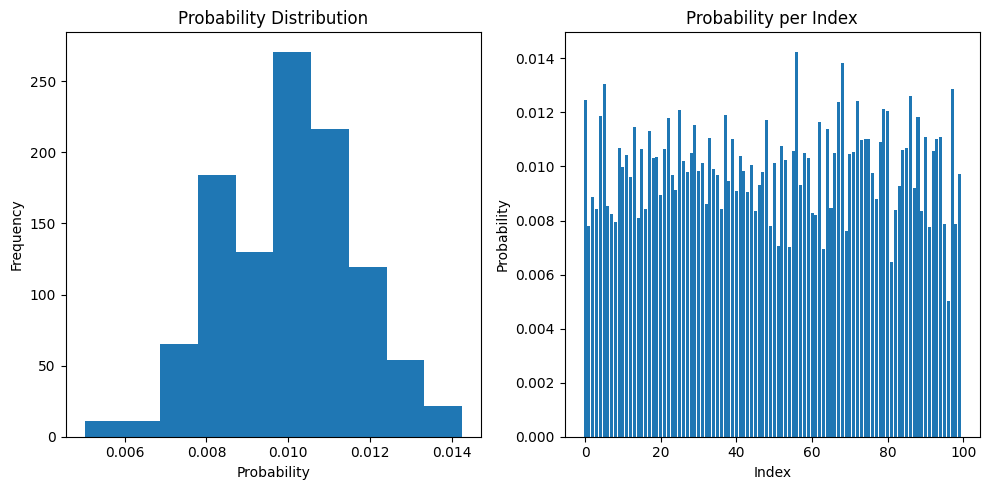

In [87]:
import matplotlib.pyplot as plt

def plot_probabilities(probabilities):
    # Create an array of indices
    indices = range(len(probabilities))

    # Create subplots: 1 row, 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Histogram on the first subplot
    axs[0].hist(probabilities, bins='auto', density=True)
    axs[0].set_title('Probability Distribution')
    axs[0].set_xlabel('Probability')
    axs[0].set_ylabel('Frequency')

    # Bar plot on the second subplot
    axs[1].bar(indices, probabilities)
    axs[1].set_title('Probability per Index')
    axs[1].set_xlabel('Index')
    axs[1].set_ylabel('Probability')

    # Display the plots
    plt.tight_layout()  # Adjusts subplot params so that subplots fit in the figure area
    plt.show()


# Call the function
plot_probabilities(probabilities)


In [92]:
import matplotlib.pyplot as plt

def plot_histogram(ax, probabilities, label=None, color=None):
    ax.hist(probabilities, bins='auto', density=True, alpha=0.5, label=label, color=color)
    ax.set_title('Probability Distribution')
    ax.set_xlabel('Probability')
    ax.set_ylabel('Frequency')

def plot_bar(ax, probabilities, label=None, color=None):
    indices = range(len(probabilities))
    ax.bar(indices, probabilities, alpha=0.5, label=label, color=color)
    ax.set_title('Probability per Index')
    ax.set_xlabel('Index')
    ax.set_ylabel('Probability')

def plot_probabilities(probabilities1, probabilities2):
    # Create subplots: 1 row, 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Call the plot functions for the first set of probabilities
    plot_histogram(axs[0], probabilities1, label='Probabilities 1', color='blue')
    plot_bar(axs[1], probabilities1, label='Probabilities 1', color='blue')

    # Call the plot functions for the second set of probabilities
    plot_histogram(axs[0], probabilities2, label='Probabilities 2', color='red')
    plot_bar(axs[1], probabilities2, label='Probabilities 2', color='red')

    # Add legends
    axs[0].legend(loc='upper right')
    axs[1].legend(loc='upper right')

    # Display the plots
    plt.tight_layout()  # Adjusts subplot params so that subplots fit in the figure area
    plt.show()


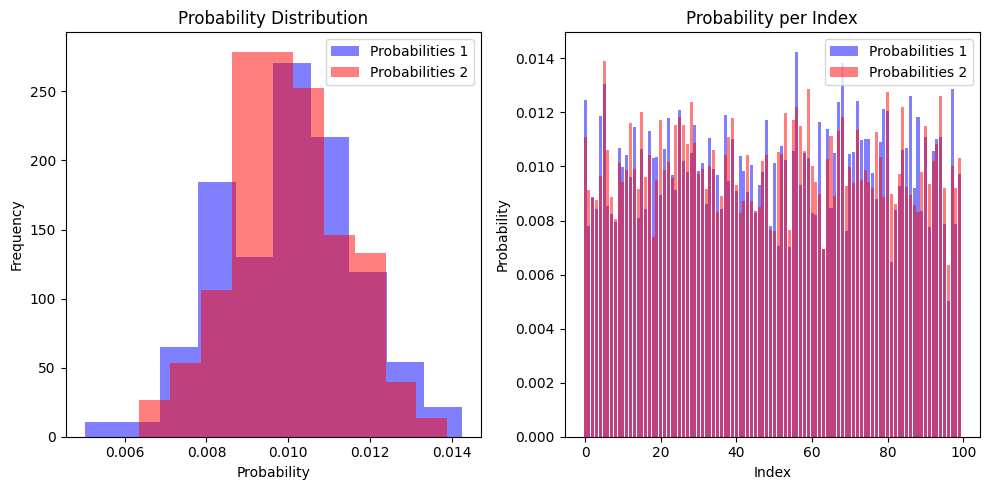

In [93]:
plot_probabilities(actor_output[:,0,:][0], actor_output[:,1,:][0])